In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2019_2020_pandemi/preprocessed_twitter_2019_2020_pandemi.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,🇺🇸 tonights sales! 🇺🇸 rare collectibles! ebay ...,0.366667,0.158333,Positive
1,1,"第一商品金地金参考価格(1kg税込) 8:45現在 販売 6,578,000円 買取 6,5...",0.000000,0.000000,Neutral
2,2,🇺🇸 tonights sales! 🇺🇸 rare collectibles! ebay ...,0.366667,0.158333,Positive
3,3,🇺🇸 tonights sales! 🇺🇸 rare collectibles! ebay ...,0.366667,0.158333,Positive
4,4,gbpusd gbpchf us100 nasdac gbpnzd gbpcad us30 ...,0.000000,0.000000,Neutral


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     56876
Positive    30290
Negative     7847
Name: Analysis, dtype: int64
Total comments:  95013


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :51


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

<ipython-input-10-3ebf70ccd52a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-3ebf70ccd52a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
print(train_labels[:10])

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [14]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [15]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
2673/2673 [==============================] - 95s 35ms/step - loss: 0.0817 - accuracy: 0.9854 - auc: 0.9993 - val_loss: 0.0457 - val_accuracy: 0.9972 - val_auc: 0.9997
Epoch 2/10
2673/2673 [==============================] - 91s 34ms/step - loss: 0.0493 - accuracy: 0.9974 - auc: 0.9997 - val_loss: 0.0427 - val_accuracy: 0.9985 - val_auc: 0.9999
Epoch 3/10
2673/2673 [==============================] - 93s 35ms/step - loss: 0.0507 - accuracy: 0.9976 - auc: 0.9997 - val_loss: 0.0396 - val_accuracy: 0.9981 - val_auc: 0.9999
Epoch 4/10
2673/2673 [==============================] - 91s 34ms/step - loss: 0.0436 - accuracy: 0.9980 - auc: 0.9998 - val_loss: 0.0403 - val_accuracy: 0.9991 - val_auc: 0.9999
Epoch 5/10
2673/2673 [==============================] - 95s 36ms/step - loss: 0.0434 - accuracy: 0.9982 - auc: 0.9998 - val_loss: 0.0404 - val_accuracy: 0.9992 - val_auc: 1.0000
Epoch 6/10
2673/2673 [==============================] - 92s 35ms/step - loss: 0.0416 - accuracy: 0.9984 - auc:

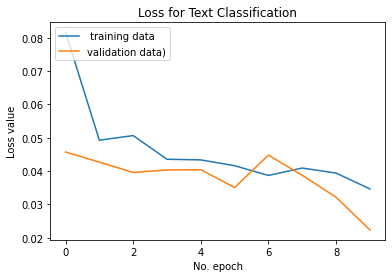

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

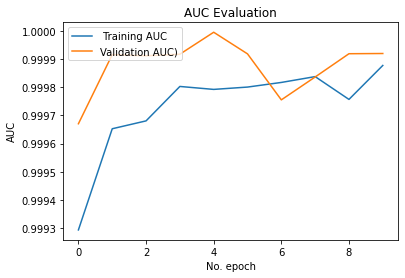

In [17]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
X_test

15678    gold sell 1728.00 target 1700.00 dm vip signal...
44203    le goat des films pour moi. bien sur il y en t...
1218     sb intraday update • $dxy • gold • $usdjpy • $...
92110    😎 voting guys choi seungcheol!!!! seventeen ca...
24998    crypto exchange facts! bitfinex pros! highly t...
                               ...                        
42703    weniger stress – mehr entspannung | stress - r...
12487    corona dünya genelinde artış göstermeye tekrar...
8060     15-19 haziran beklentilerim altın fiyatları bu...
18180    think it’s likely gold sell markets broadly. k...
23930    💵 tfc (tf coin) cash airdrop free 300 tfc+50 r...
Name: tweet, Length: 9502, dtype: object

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-19-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
297/297 [==============================] - 2s 7ms/step


array([1, 1, 1, ..., 2, 2, 2])

In [21]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [22]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00      3082
    Negative       1.00      1.00      1.00       744
     Neutral       1.00      1.00      1.00      5676

    accuracy                           1.00      9502
   macro avg       1.00      1.00      1.00      9502
weighted avg       1.00      1.00      1.00      9502

